## ATAC + MULTIOME (females)

### Label transfer with Seurat 

In [35]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.figdir = '/home/jovyan/MULTIOME_april2021/figures_females/'

In [36]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [37]:
import rpy2.rinterface_lib.callbacks
import logging

In [38]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [39]:
import anndata2ri
anndata2ri.activate()

In [40]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [41]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(Seurat)
library(dplyr)
library(data.table)
library(GenomicRanges)
library(EnsDb.Hsapiens.v86)
#library(cicero)
library(Signac)
#library(clustree)
library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)

**Load data**

In [42]:
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/females_apr2021/"
experiment_prefix = 'females_'

Try to use the gene accessibility scores computed with Emma's method and integrate with matched scRNAseq samples annotated by Luz 

In [9]:
%%R -i outdir -i experiment_prefix -o ATAC_geneScores
Convert(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"), overwrite = TRUE)
ATAC_geneScores <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"))
ATAC_geneScores
table(ATAC_geneScores@meta.data$individual)

[1]  8595  1169  3449  4798 15251  8657 20436  4929  5256


In [10]:
%%R -i outdir -i experiment_prefix -o RNAseq
Convert(paste0(outdir, experiment_prefix, "_RNAseq.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"), overwrite = TRUE)
RNAseq <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"))
RNAseq
table(RNAseq@meta.data$individual)

[1]  7844  2039  1335  2030  2647  9418 17072  2600


In [11]:
%%R -i RNAseq

print(table(RNAseq@meta.data$annotated_clusters)) 


     Endothelial       Epithelial        Erythroid       Germ cells 
            2202             4414             2052             1774 
              Gi           Immune           M_ALX1            M_MGP 
            1768              935              396             6298 
M_MullDuct_AMHR2  M_MullDuct_LGR5      M_prog_ISL1           Neural 
             344             4391              252              526 
              Oi          Oi-like               PV          coelEpi 
            3448             1156             3343              473 
     ovarianSurf   preGC_III_GJA1   preGC_II_KITLG     preGC_I_OSR1 
             947             2451             3300             3560 
          sKITLG            sLGR5            sPAX8 
             146              501              308 


**Try label transfer with major cluster annotations**

In [12]:
%%R -i RNAseq -i ATAC_geneScores -o RNA2ATAC

# Normalize both RNA and ATAC data
RNAseq <- NormalizeData(object = RNAseq, verbose = TRUE)
ATAC_geneScores <- NormalizeData(object = ATAC_geneScores, verbose = TRUE)

# Find HVGs in both RNA and ATAC data
RNAseq  <- FindVariableFeatures(object = RNAseq, selection.method = "vst", nfeatures = 3000, verbose = TRUE)
ATAC_geneScores <- FindVariableFeatures(object = ATAC_geneScores, selection.method = "vst", nfeatures = 3000, verbose = TRUE)

# Find anchors to do integration using RNA as reference and ATAC as query 
transfer_anchors <- FindTransferAnchors(reference = RNAseq, query = ATAC_geneScores, 
    dims = 1:25, reduction = "cca")

# Transfer labels from RNA to ATAC
RNA2ATAC <- TransferData(anchorset = transfer_anchors, refdata = RNAseq@meta.data$annotated_clusters, dims = 1:25, weight.reduction = "cca",
                        prediction.assay = TRUE)

# Add metadata to ATAC
#ATAC_geneScores_labels <- AddMetaData(object = ATAC_geneScores, metadata = RNA2ATAC)

In [13]:
%%R -i RNA2ATAC -o predicted_probabilities -i ATAC_geneScores

ATAC_geneScores[['scores']] <- RNA2ATAC
ATAC_geneScores
DefaultAssay(ATAC_geneScores) <- "scores" # Change default assay 
predicted_probabilities <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_geneScores))))

In [14]:
predicted_probabilities

preGC-III-GJA1  preGC-II-KITLG     sLGR5  ovarianSurf  \
01-AAACGAAAGGCTCCTG-1        0.000000        0.000000  0.250140     0.000000   
01-AAACGAAAGTCCAGAG-1        0.038876        0.000000  0.582534     0.000000   
01-AAACGAACACCCATCT-1        0.000000        0.006084  0.000000     0.760955   
01-AAACGAACAGGTCTGC-1        0.000000        0.000000  0.246841     0.000000   
01-AAACGAACATAGCCAT-1        0.317326        0.100579  0.000000     0.000000   
...                               ...             ...       ...          ...   
12-TTTGTGTCACGCGACT-1        0.004950        0.005188  0.000000     0.000000   
12-TTTGTGTCATTCCCGT-1        0.000000        0.000000  0.000000     0.000000   
12-TTTGTGTGTGCTGAAG-1        0.966669        0.003087  0.000000     0.000000   
12-TTTGTGTGTTAACCGT-1        1.000000        0.000000  0.000000     0.000000   
12-TTTGTGTGTTAAGTCC-1        0.001471        0.006714  0.000254     0.000000   

                       preGC-I-OSR1        Gi        Oi   Oi-like  \
01-AAACGAAAGGCTCCTG-1      0.682257  0.000000  0.000000  0.006225   
01-AAACGAAAGTCCAGAG-1      0.324713  0.000000  0.000000  0.008702   
01-AAACGAACACCCATCT-1      0.000000  0.000000  0.000000  0.000000   
01-AAACGAACAGGTCTGC-1      0.662122  0.000000  0.000000  0.014492   
01-AAACGAACATAGCCAT-1      0.041472  0.137902  0.000000  0.103905   
...                             ...       ...       ...       ...   
12-TTTGTGTCACGCGACT-1      0.000000  0.000000  0.000000  0.000000   
12-TTTGTGTCATTCCCGT-1      0.000000  0.000000  0.000000  0.000000   
12-TTTGTGTGTGCTGAAG-1      0.000000  0.000000  0.000000  0.000000   
12-TTTGTGTGTTAACCGT-1      0.000000  0.000000  0.000000  0.000000   
12-TTTGTGTGTTAAGTCC-1      0.000264  0.000000  0.001566  0.000000   

                       Endothelial     sPAX8  ...  Neural  sKITLG        PV  \
01-AAACGAAAGGCTCCTG-1     0.000000  0.061378  ...     0.0     0.0  0.000000   
01-AAACGAAAGTCCAGAG-1     0.000000  0.045175  ...     0.0     0.0  0.000000   
01-AAACGAACACCCATCT-1     0.000000  0.000000  ...     0.0     0.0  0.000000   
01-AAACGAACAGGTCTGC-1     0.000000  0.076546  ...     0.0     0.0  0.000000   
01-AAACGAACATAGCCAT-1     0.000000  0.000000  ...     0.0     0.0  0.107798   
...                            ...       ...  ...     ...     ...       ...   
12-TTTGTGTCACGCGACT-1     0.000644  0.000000  ...     0.0     0.0  0.000000   
12-TTTGTGTCATTCCCGT-1     0.000000  0.000000  ...     0.0     0.0  0.883725   
12-TTTGTGTGTGCTGAAG-1     0.000000  0.000000  ...     0.0     0.0  0.000000   
12-TTTGTGTGTTAACCGT-1     0.000000  0.000000  ...     0.0     0.0  0.000000   
12-TTTGTGTGTTAAGTCC-1     0.169867  0.000000  ...     0.0     0.0  0.000000   

                       Germ cells  Erythroid    M-ALX1  M-prog-ISL1    Immune  \
01-AAACGAAAGGCTCCTG-1         0.0   0.000000  0.000000          0.0  0.000000   
01-AAACGAAAGTCCAGAG-1         0.0   0.000000  0.000000          0.0  0.000000   
01-AAACGAACACCCATCT-1         0.0   0.000000  0.000000          0.0  0.000000   
01-AAACGAACAGGTCTGC-1         0.0   0.000000  0.000000          0.0  0.000000   
01-AAACGAACATAGCCAT-1         0.0   0.000000  0.000000          0.0  0.000000   
...                           ...        ...       ...          ...       ...   
12-TTTGTGTCACGCGACT-1         0.0   0.000000  0.000000          0.0  0.000000   
12-TTTGTGTCATTCCCGT-1         0.0   0.000000  0.010326          0.0  0.000000   
12-TTTGTGTGTGCTGAAG-1         0.0   0.030244  0.000000          0.0  0.000000   
12-TTTGTGTGTTAACCGT-1         0.0   0.000000  0.000000          0.0  0.000000   
12-TTTGTGTGTTAAGTCC-1         0.0   0.188516  0.000000          0.0  0.631348   

                       M-MullDuct-LGR5       max  
01-AAACGAAAGGCTCCTG-1           0.0000  0.682257  
01-AAACGAAAGTCCAGAG-1           0.0000  0.582534  
01-AAACGAACACCCATCT-1           0.0000  0.760955  
01-AAACGAACAGGTCTGC-1           0.0000  0.662122  
01-AAACGAACATAGCCAT-1           0.0677  0.317326  
...  

In [15]:
predicted_probabilities.columns

Index(['preGC-III-GJA1', 'preGC-II-KITLG', 'sLGR5', 'ovarianSurf',
       'preGC-I-OSR1', 'Gi', 'Oi', 'Oi-like', 'Endothelial', 'sPAX8', 'M-MGP',
       'M-MullDuct-AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV',
       'Germ cells', 'Erythroid', 'M-ALX1', 'M-prog-ISL1', 'Immune',
       'M-MullDuct-LGR5', 'max'],
      dtype='object')

Replace dashes with underscores as stupid R changes them

In [16]:
predicted_probabilities.columns = ['preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf',
       'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP',
       'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV',
       'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune',
       'M_MullDuct_LGR5', 'max']

**Save the predicted annotations to the gene activity anndata object for ATAC**

In [17]:
gene_data = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [18]:
for pred in predicted_probabilities.columns: 
    print(pred)
    gene_data.obs[pred] = predicted_probabilities[pred]

preGC_III_GJA1
preGC_II_KITLG
sLGR5
ovarianSurf
preGC_I_OSR1
Gi
Oi
Oi_like
Endothelial
sPAX8
M_MGP
M_MullDuct_AMHR2
Epithelial
coelEpi
Neural
sKITLG
PV
Germ cells
Erythroid
M_ALX1
M_prog_ISL1
Immune
M_MullDuct_LGR5
max


In [50]:
gonads_colors = ['#c466b0','#e64e74',  '#60bddb', '#edb7b7', '#779eed', '#7b9e99',  '#ebd3c3' ,'#70ccbe', 
               '#7b9e99', '#edb7b7', '#91bd80', '#d9a5c3','#cc8fdb', '#71a2c7','#bdb380',  '#d4db81', '#ebd3c3',  '#dba781',  '#60bddb', 
               '#e08b8b', '#d9abb7','#aad3f2', '#d96884', '#e64e74',  ]

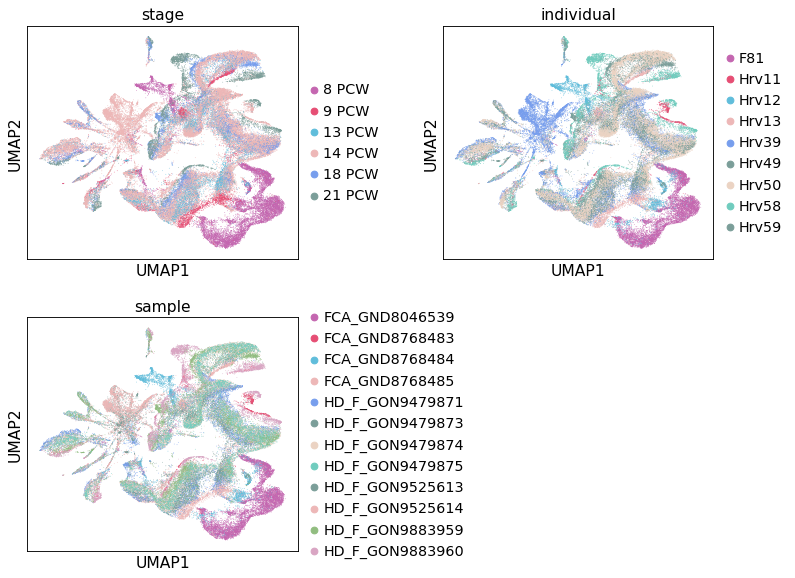

In [20]:
sc.pl.umap(gene_data, color = ['stage', 'individual', 'sample'], ncols = 2, wspace = 0.4, 
           palette = gonads_colors, save = "_noharmony.pdf")

In [21]:
gene_data.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage',
       'individual', 'preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5',
       'ovarianSurf', 'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial',
       'sPAX8', 'M_MGP', 'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural',
       'sKITLG', 'PV', 'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1',
       'Immune', 'M_MullDuct_LGR5', 'max'],
      dtype='object')

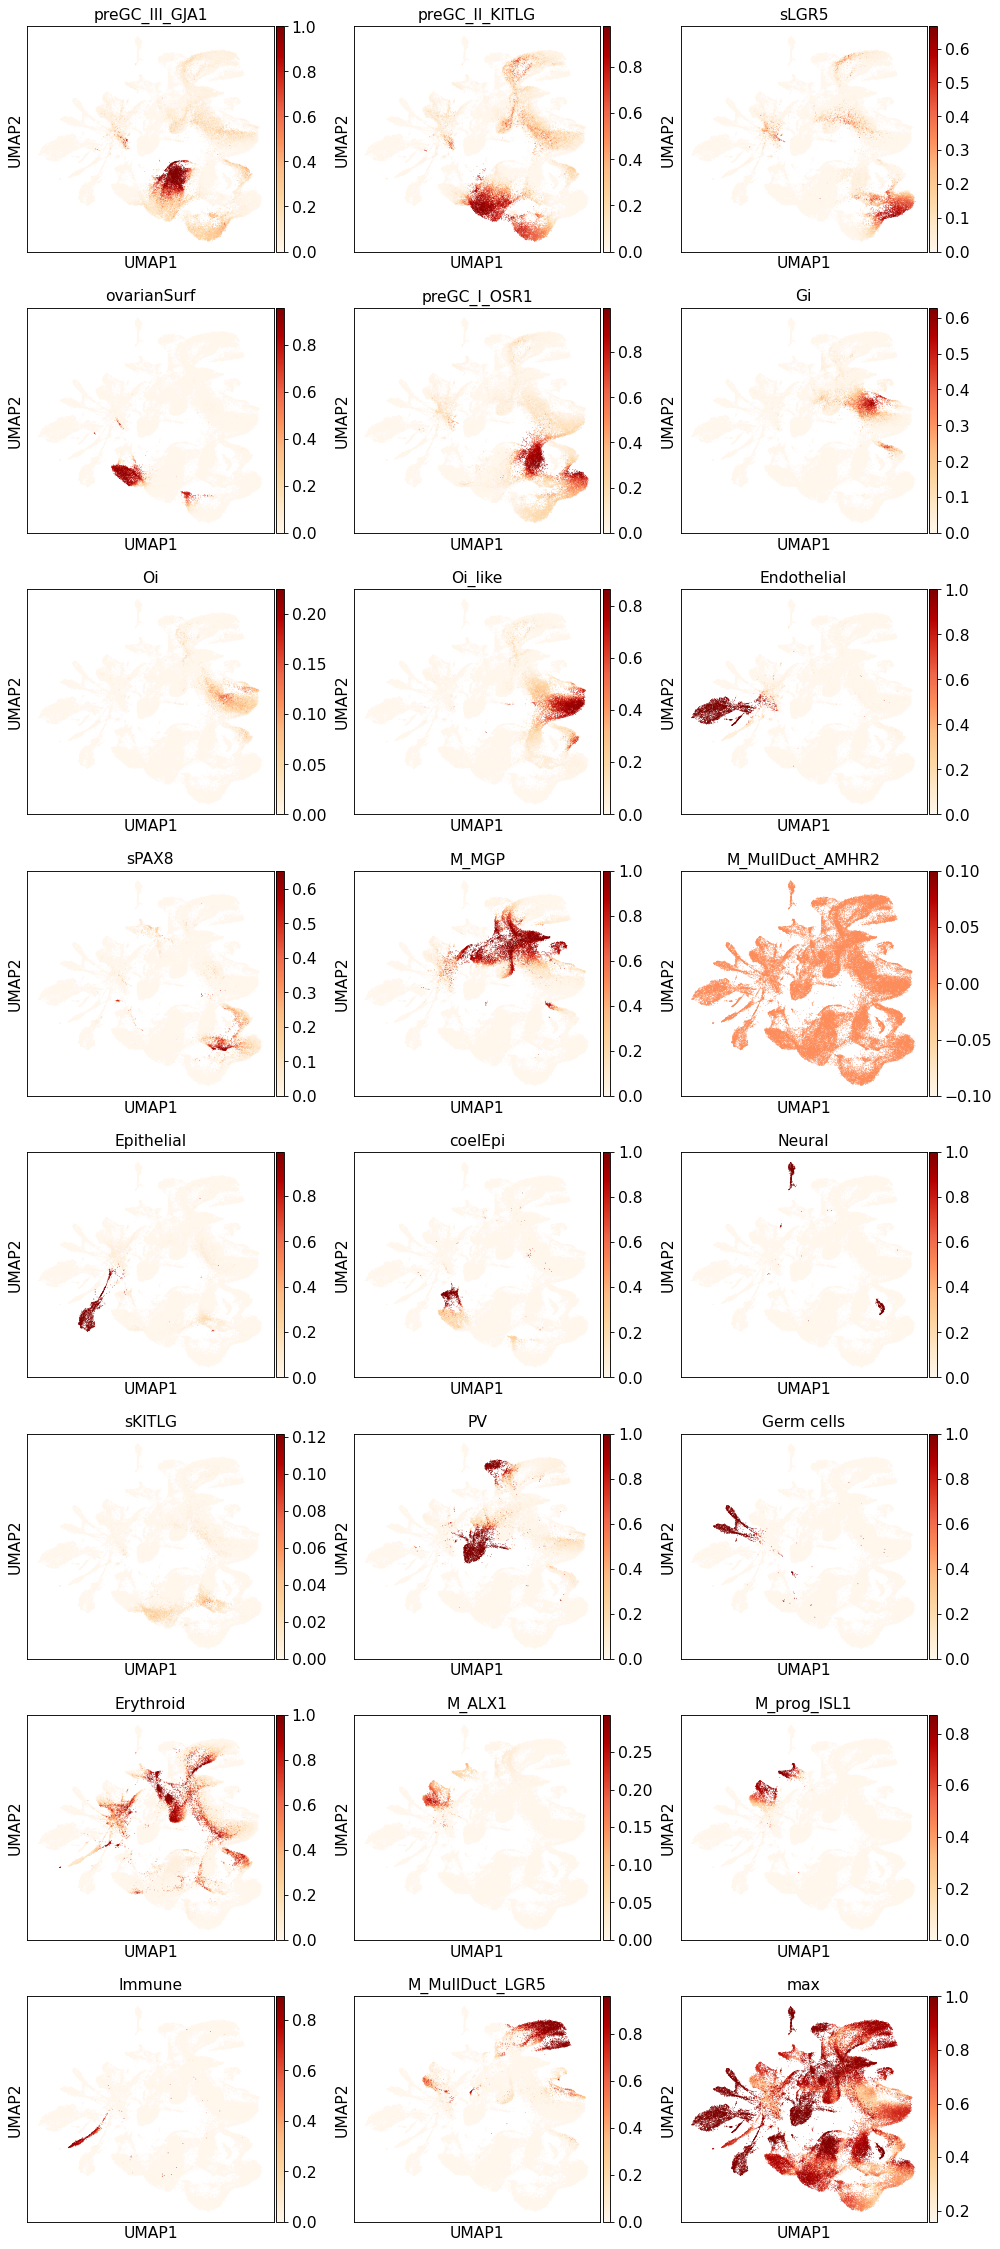

In [22]:
sc.pl.umap(gene_data, color = [ 'preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf',
       'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP',
       'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV',
       'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune',
       'M_MullDuct_LGR5', 'max'], ncols = 3, color_map = 'OrRd', save = "_probs_noharmony.pdf")

#### Look at average gene activity scores to identify cycling population

This was suggested by Luz 

In [23]:
gene_data.X

array([[37., 39., 48., ..., 18., 19., 34.],
       [33., 35., 46., ..., 22., 17., 33.],
       [42., 42., 42., ..., 30., 18., 34.],
       ...,
       [51., 51., 44., ..., 22., 32., 65.],
       [47., 47., 38., ..., 21., 30., 63.],
       [79., 69., 65., ..., 27., 29., 28.]], dtype=float32)

In [24]:
mean_by_cell = gene_data.X.mean(axis=1)
mean_by_cell

array([51.17661 , 50.286182, 49.957222, ..., 50.547012, 49.72882 ,
       55.400803], dtype=float32)

In [25]:
means = pd.DataFrame(mean_by_cell, columns=['mean_gene_activity'], index=gene_data.obs_names)
means.head()

mean_gene_activity
01-AAACGAAAGGCTCCTG-1           51.176609
01-AAACGAAAGTCCAGAG-1           50.286182
01-AAACGAACACCCATCT-1           49.957222
01-AAACGAACAGGTCTGC-1           51.538692
01-AAACGAACATAGCCAT-1           49.336735

In [26]:
gene_data.obs['mean_gene_activity'] = means

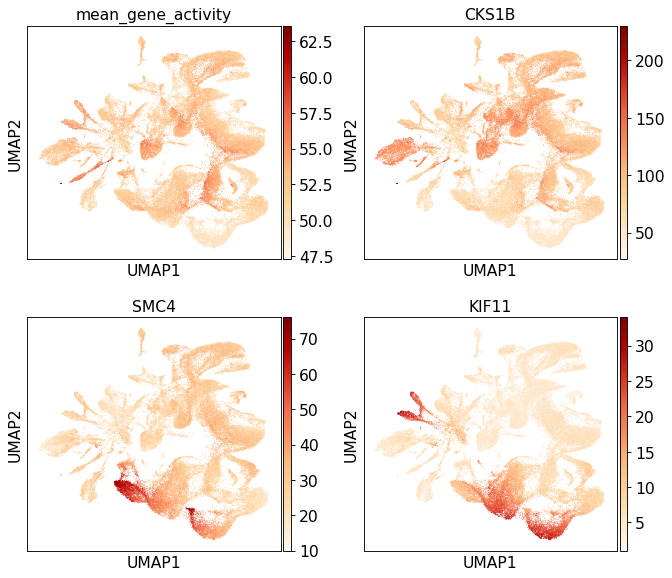

In [27]:
sc.pl.umap(gene_data, color = ['mean_gene_activity', 'CKS1B', 'SMC4', 'KIF11'], ncols = 2, color_map = "OrRd")

In [28]:
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in gene_data.var_names]
print(s_genes)
g2m_genes = [x for x in g2m_genes if x in gene_data.var_names]
print(g2m_genes)

['MCM5', 'FEN1', 'MCM2', 'UNG', 'GINS2', 'MCM6', 'DTL', 'UHRF1', 'RFC2', 'NASP', 'RAD51AP1', 'WDR76', 'POLD3', 'MSH2', 'ATAD2', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'BLM', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
['BIRC5', 'TPX2', 'TOP2A', 'NUF2', 'CKS1B', 'CENPF', 'TACC3', 'SMC4', 'CKAP2L', 'AURKB', 'KIF11', 'GTSE1', 'HJURP', 'RANGAP1', 'NCAPD2', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CTCF', 'NEK2', 'GAS2L3', 'CBX5', 'CENPA']


In [29]:
#sc.pl.umap(gene_data, color = s_genes, color_map = "OrRd")

In [30]:
#sc.pl.umap(gene_data, color = g2m_genes, color_map = "OrRd")

In [31]:
gene_data.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

**Save the predicted annotations to the peaks anndata object for ATAC**

In [32]:
adata = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 72540 × 201343
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'leiden', 'leiden_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_40', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivities', 'distances'

In [33]:
for pred in predicted_probabilities.columns: 
    print(pred)
    adata.obs[pred] = predicted_probabilities[pred]

preGC_III_GJA1
preGC_II_KITLG
sLGR5
ovarianSurf
preGC_I_OSR1
Gi
Oi
Oi_like
Endothelial
sPAX8
M_MGP
M_MullDuct_AMHR2
Epithelial
coelEpi
Neural
sKITLG
PV
Germ cells
Erythroid
M_ALX1
M_prog_ISL1
Immune
M_MullDuct_LGR5
max


In [34]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

#### Import annotations from dual to remove what is mesenchymal reproductive tract

In [35]:
annotations_dualRNA = pd.read_csv("/nfs/team292/lg18/with_valentina/gonadsV1_freezed/dual_snRNAsnATAC_female_Hrv39.csv", index_col = 0)
annotations_dualRNA.head()

n_genes              sample  donor  \
HD_F_GON9525421_AAACAGCCAACAACAA      986  b'HD_F_GON9525421'  Hrv39   
HD_F_GON9525421_AAACATGCACACCAAC     2474  b'HD_F_GON9525421'  Hrv39   
HD_F_GON9525421_AAACCAACAACACTTG     3723  b'HD_F_GON9525421'  Hrv39   
HD_F_GON9525421_AAACCAACACCTACTT     3237  b'HD_F_GON9525421'  Hrv39   
HD_F_GON9525421_AAACCGAAGCCTGGTA     6198  b'HD_F_GON9525421'  Hrv39   

                                          Library_ATAC  Library_RNA      iRods_path  \
HD_F_GON9525421_AAACAGCCAACAACAA  b'HD_F_GON9525613        HD_F_GON9525421      ...   
HD_F_GON9525421_AAACATGCACACCAAC  b'HD_F_GON9525613        HD_F_GON9525421      ...   
HD_F_GON9525421_AAACCAACAACACTTG  b'HD_F_GON9525613        HD_F_GON9525421      ...   
HD_F_GON9525421_AAACCAACACCTACTT  b'HD_F_GON9525613        HD_F_GON9525421      ...   
HD_F_GON9525421_AAACCGAAGCCTGGTA  b'HD_F_GON9525613        HD_F_GON9525421      ...   

                                  percent_mito  n_counts batch  \
HD_F_GON9525421_AAACAGCCAACAACAA      0.000000    1122.0  b'2'   
HD_F_GON9525421_AAACATGCACACCAAC      0.000189    4968.0  b'2'   
HD_F_GON9525421_AAACCAACAACACTTG      0.000604    3938.0  b'2'   
HD_F_GON9525421_AAACCAACACCTACTT      0.000695    7179.0  b'2'   
HD_F_GON9525421_AAACCGAAGCCTGGTA      0.001147   12587.0  b'2'   

                                  scrublet_score  scrublet_cluster_score  \
HD_F_GON9525421_AAACAGCCAACAACAA        0.176471                0.170279   
HD_F_GON9525421_AAACATGCACACCAAC        0.104072                0.142857   
HD_F_GON9525421_AAACCAACAACACTTG        0.243697                0.243697   
HD_F_GON9525421_AAACCAACACCTACTT        0.117647                0.125320   
HD_F_GON9525421_AAACCGAAGCCTGGTA        0.142857                0.152941   

                                    zscore   bh_pval  bonf_pval  is_doublet  \
HD_F_GON9525421_AAACAGCCAACAACAA  0.550242  0.933846        1.0       False   
HD_F_GON9525421_AAACATGCACACCAAC  0.000000  0.933846        1.0       False   
HD_F_GON9525421_AAACCAACAACACTTG  2.023472  0.480450        1.0       False   
HD_F_GON9525421_AAACCAACACCTACTT -0.351908  0.933846        1.0       False   
HD_F_GON9525421_AAACCGAAGCCTGGTA  0.202347  0.933846        1.0       False   

                                  leiden          clusters  leiden_R  
HD_F_GON9525421_AAACAGCCAACAACAA       0       Mesenchymal         0  
HD_F_GON9525421_AAACATGCACACCAAC       1  Mesenchymal_meso         1  
HD_F_GON9525421_AAACCAACAACACTTG       1  Mesenchymal_meso         1  
HD_F_GON9525421_AAACCAACACCTACTT       6        Epithelial         6  
HD_F_GON9525421_AAACCGAAGCCTGGTA       4        Germ cells         4

In [36]:
annotations_dualRNA.shape

(5102, 16)

In [37]:
annotations_dualRNA['clusters'].value_counts(dropna = False)

Mesenchymal          1780
Mesenchymal_meso     1367
Mesenchymal_lowQC     972
Supporting            458
Germ cells            199
Endothelial            98
Epithelial             95
Immune                 63
Doublet                42
unknown                28
Name: clusters, dtype: int64

In [38]:
adata.obs[['code', 'sample']].value_counts()

code  sample         
07    HD_F_GON9479874    12296
05    HD_F_GON9479871     9585
06    HD_F_GON9479873     8657
01    FCA_GND8046539      8595
08    HD_F_GON9479875     8140
11    HD_F_GON9883959     5256
12    HD_F_GON9883960     4929
04    FCA_GND8768485      4798
10    HD_F_GON9525614     3597
03    FCA_GND8768484      3449
09    HD_F_GON9525613     2069
02    FCA_GND8768483      1169
dtype: int64

In [39]:
annotations_dualRNA.index = [i.replace("HD_F_GON9525421_", "09-") for i in annotations_dualRNA.index]
annotations_dualRNA.index = [i.replace("HD_F_GON9525422_", "10-") for i in annotations_dualRNA.index]
annotations_dualRNA.index = [i + "-1" for i in annotations_dualRNA.index]

In [40]:
dualRNA_mapping = annotations_dualRNA['clusters'].to_dict()
adata.obs['dualRNA_label'] = adata.obs_names.map(dualRNA_mapping)
adata.obs['dualRNA_label'].value_counts(dropna = False)

NaN                  67547
Mesenchymal           1760
Mesenchymal_meso      1346
Mesenchymal_lowQC      926
Supporting             448
Germ cells             196
Endothelial             96
Epithelial              93
Immune                  61
Doublet                 39
unknown                 28
Name: dualRNA_label, dtype: int64

... storing 'dualRNA_label' as categorical


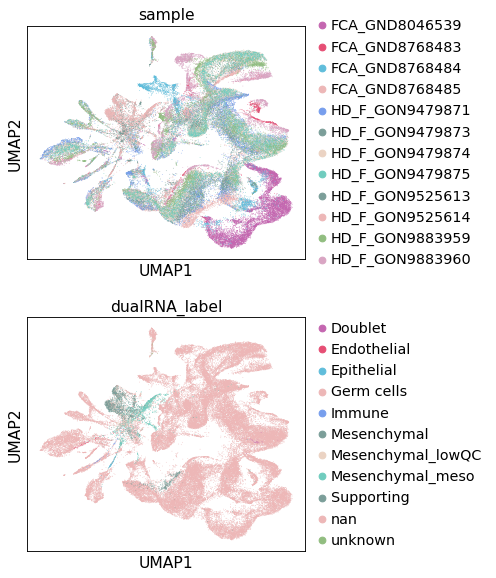

In [41]:
sc.pl.umap(adata, color = ['sample', 'dualRNA_label'], ncols = 1, palette = gonads_colors)

In [42]:
### Remove barcodes from reproductive tract 
adata = adata[[i not in ['Mesenchymal', 'Mesenchymal_lowQC', 'Mesenchymal_meso', 'unknown', 'Doublet'] for i in adata.obs['dualRNA_label']]]
adata.shape

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(68441, 201343)

Trying to set attribute `.uns` of view, copying.


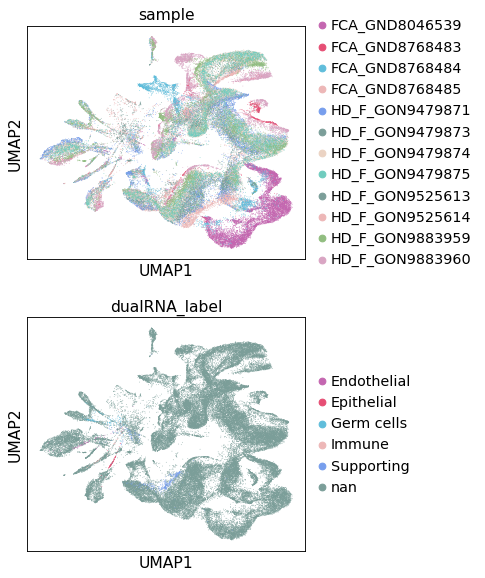

In [43]:
sc.pl.umap(adata, color = ['sample', 'dualRNA_label'], ncols = 1, palette = gonads_colors)

### Harmony integration

In [44]:
adata

AnnData object with n_obs × n_vars = 68441 × 201343
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf', 'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP', 'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV', 'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune', 'M_MullDuct_LGR5', 'max', 'dualRNA_label'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'le

In [45]:
# Extract PCA matrix and batch array
n_pcs = 40
pca = adata.obsm['X_cistopic_40'][:, 0:(n_pcs)]
batch = adata.obs['individual']

In [46]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=0, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

In [47]:
# Add harmony values to the anndata object
adata.obsm['X_harmony'] = hem.values

In [48]:
sc.pp.neighbors(adata, use_rep= 'X_harmony', random_state=1234)
sc.tl.umap(adata)

/opt/conda/envs/atac_env/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:316: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 28] No space left on device
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))


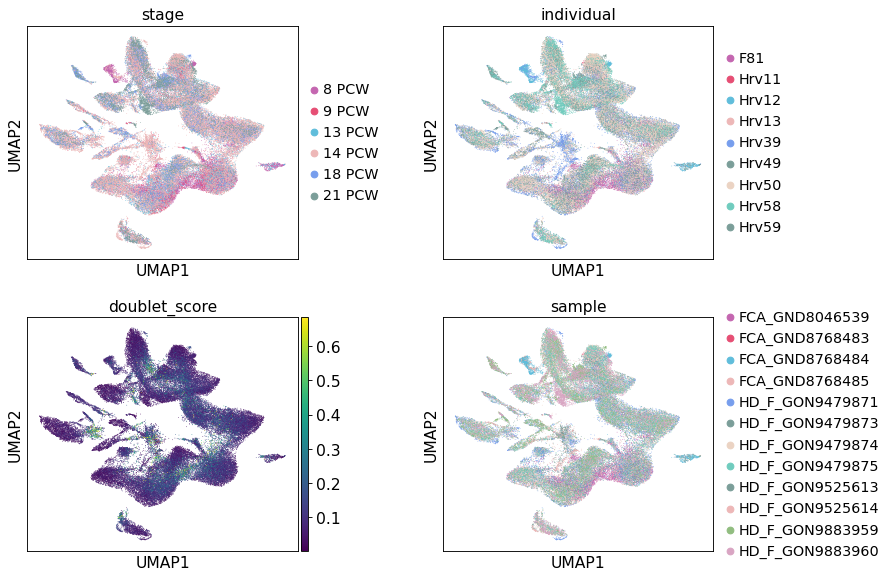

In [49]:
sc.pl.umap(adata, color = ['stage', 'individual', 'doublet_score', 'sample'], ncols = 2, wspace = 0.4, 
           palette = gonads_colors, save = "metadata.pdf")

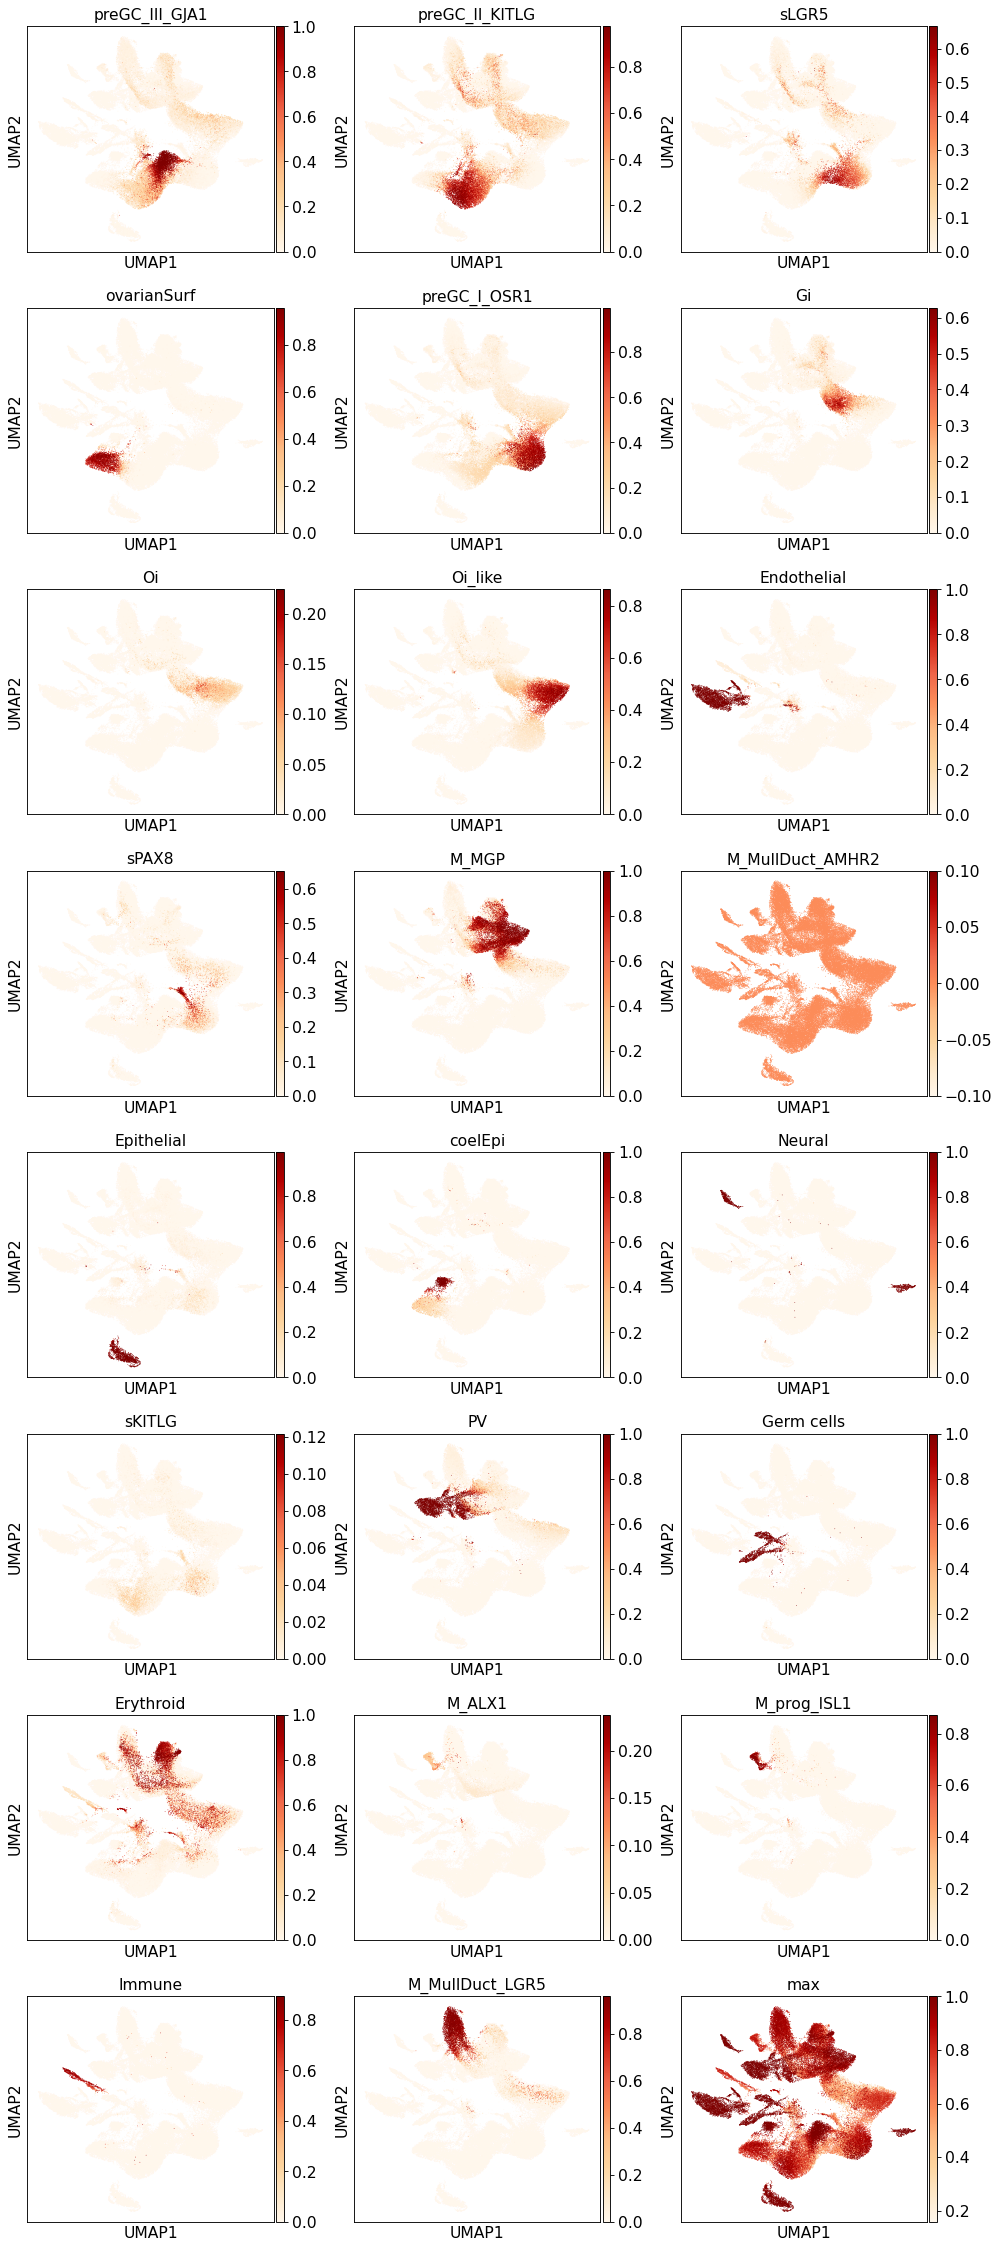

In [50]:
sc.pl.umap(adata, color = ['preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf',
       'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP',
       'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV',
       'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune',
       'M_MullDuct_LGR5', 'max'], ncols = 3, color_map = 'OrRd', save = "_probs_harmony.pdf")

#### Visualize position in the manifold of dual ATAC samples

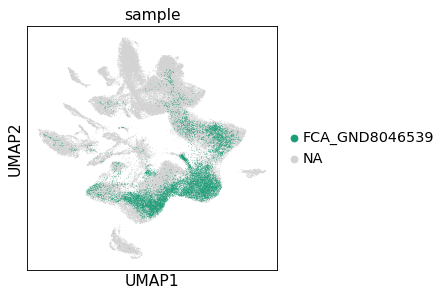

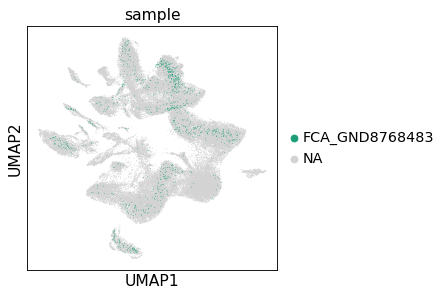

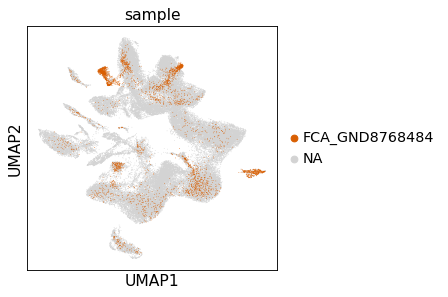

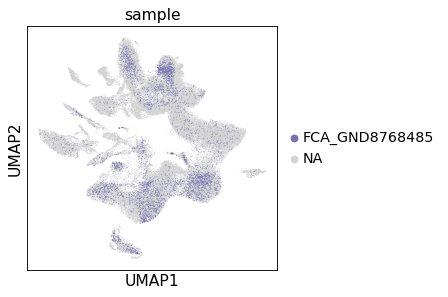

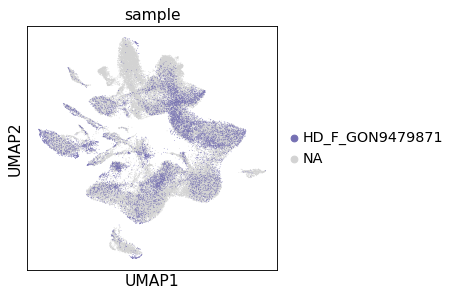

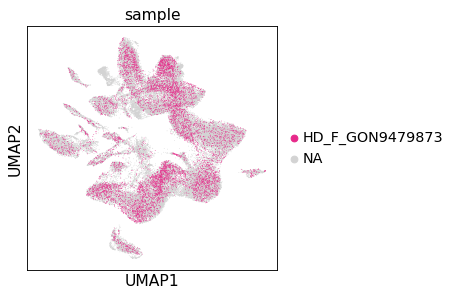

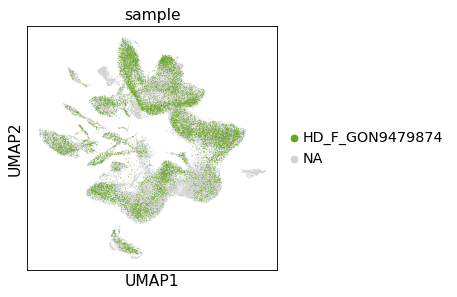

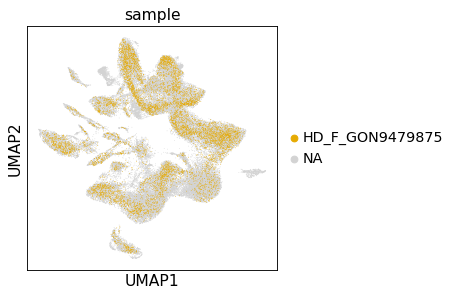

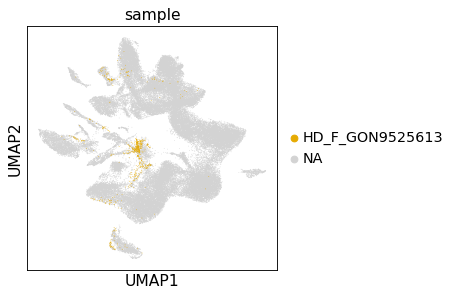

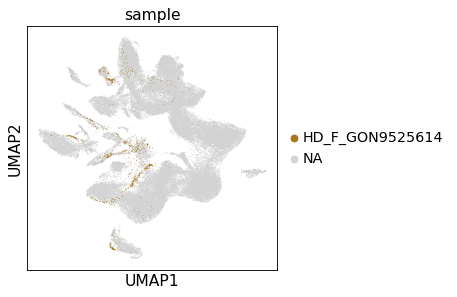

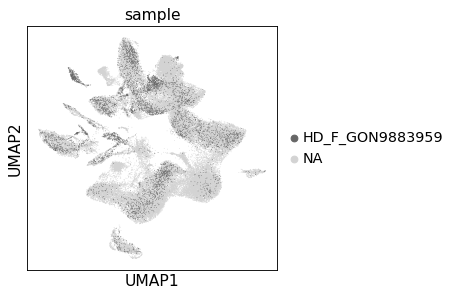

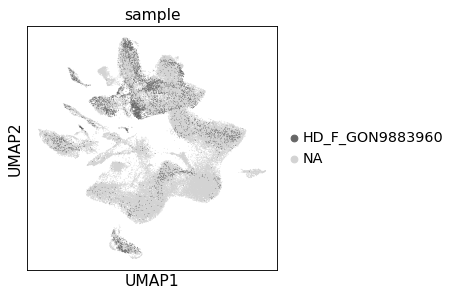

In [51]:
for sample in np.unique(adata.obs['sample']):
    sc.pl.umap(adata, color = 'sample', groups = sample, palette = 'Dark2', save = sample + ".pdf")

#### Clustering

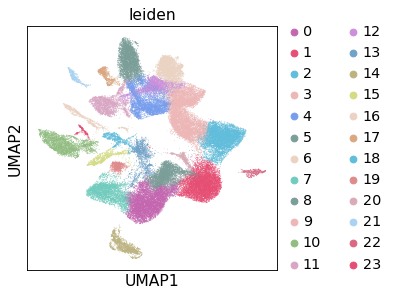

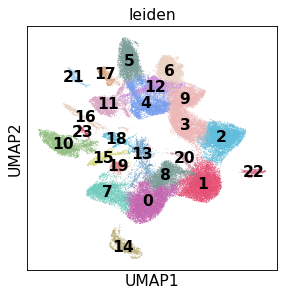

In [56]:
sc.tl.leiden(adata, resolution=0.7, random_state = 1234)
sc.pl.umap(adata, color='leiden',save='_clustering.pdf')
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_clustering_clusnumbers.pdf', palette = gonads_colors)

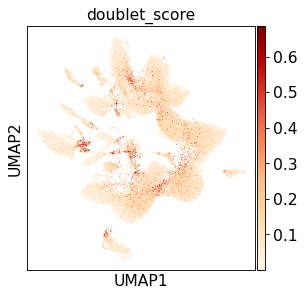

In [53]:
sc.pl.umap(adata, color = ['doublet_score'], color_map = 'OrRd')

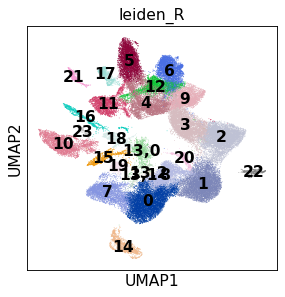

In [63]:
sc.tl.leiden(adata, resolution=0.07, random_state = 1234, restrict_to = ('leiden', ['13']))
sc.pl.umap(adata, color='leiden_R', legend_loc = 'on data', save='_clustering.pdf')

In [64]:
# Remove clusters of doublets
adata = adata[[i not in ['13,0'] for i in adata.obs['leiden_R']]]
adata.shape

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(67202, 201343)

Trying to set attribute `.obs` of view, copying.


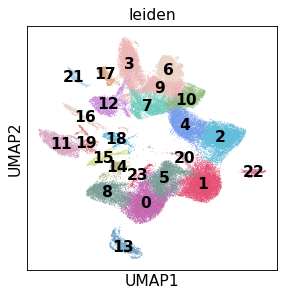

In [65]:
sc.tl.leiden(adata, resolution= 0.7, random_state = 1234)
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_clustering_clusnumbers.pdf', palette = gonads_colors)

In [66]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

In [67]:
adata = sc.read(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

#### Matrixplot of label transfer predictions vs leiden clusters

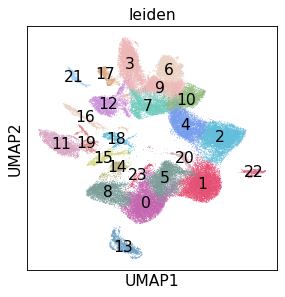

In [51]:
sc.pl.umap(adata, color='leiden',legend_loc='on data', palette = gonads_colors, 
          legend_fontsize = 'medium', legend_fontweight = 'medium',save='_clustering_clusnumbers.pdf')

In [17]:
adata.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage',
       'individual', 'doublet_score', 'doublet_score_0.75', 'leiden',
       'preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf',
       'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP',
       'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV',
       'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune',
       'M_MullDuct_LGR5', 'max', 'dualRNA_label', 'leiden_R', 'cell_type'],
      dtype='object')

In [18]:
obs = adata.obs[['preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf',
       'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP',
       'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV',
       'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune',
       'M_MullDuct_LGR5',]]

In [19]:
matrix = obs[['preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf',
       'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP',
       'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV',
       'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune',
       'M_MullDuct_LGR5',]].values
matrix.shape

(67202, 23)

In [20]:
plotting_obs = adata.obs[['leiden', 'cell_type']]
plotting_obs.shape

(67202, 2)

In [21]:
plotting_probs = ['preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf',
       'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP',
       'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV',
       'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune',
       'M_MullDuct_LGR5',]
plotting_var_dict = {'probs' : plotting_probs, 'random_string' : [str(i) for i in range(23)]}
plotting_var = pd.DataFrame(plotting_var_dict)
plotting_var = plotting_var.set_index('probs')
plotting_var.head()
plotting_var.shape

(23, 1)

In [22]:
plotting_adata = anndata.AnnData(X = matrix, obs = plotting_obs, var = plotting_var)
plotting_adata

AnnData object with n_obs × n_vars = 67202 × 23
    obs: 'leiden', 'cell_type'
    var: 'random_string'

In [23]:
ordered_probs = ['Germ cells','coelEpi', 'sPAX8', 'preGC_I_OSR1',
                'ovarianSurf','preGC_II_KITLG', 'preGC_III_GJA1',
                        'Oi_like',  'Gi', 
                    'M_prog_ISL1', 'M_MGP',  'M_MullDuct_LGR5', 
                    'PV','Epithelial', 'Endothelial', 'Immune','Neural', 'sKITLG',  'sLGR5', 'M_ALX1', 'M_MullDuct_AMHR2', 'Erythroid']

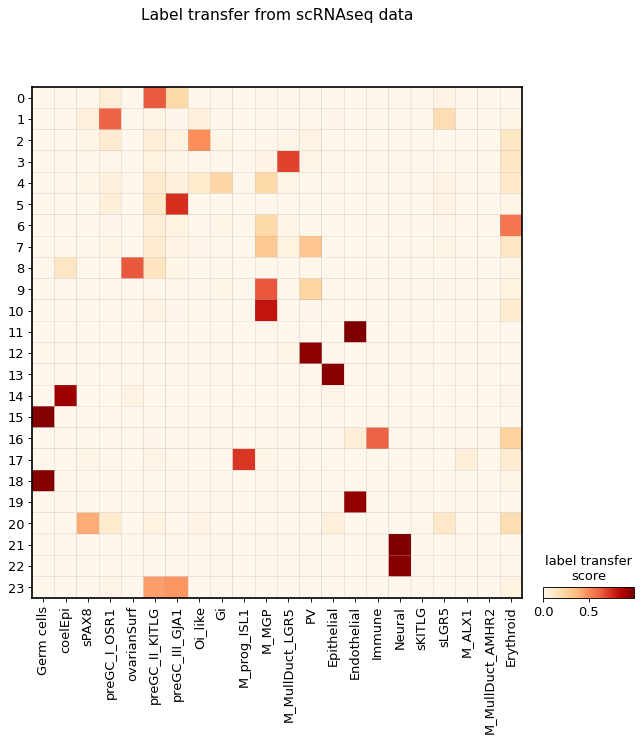

In [24]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'leiden', cmap = 'OrRd',
                  save = '_matrixplot.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

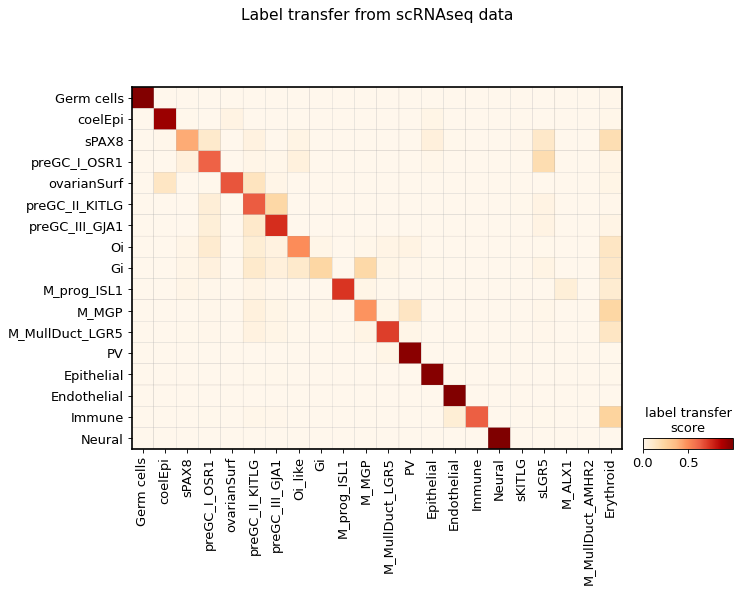

In [25]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

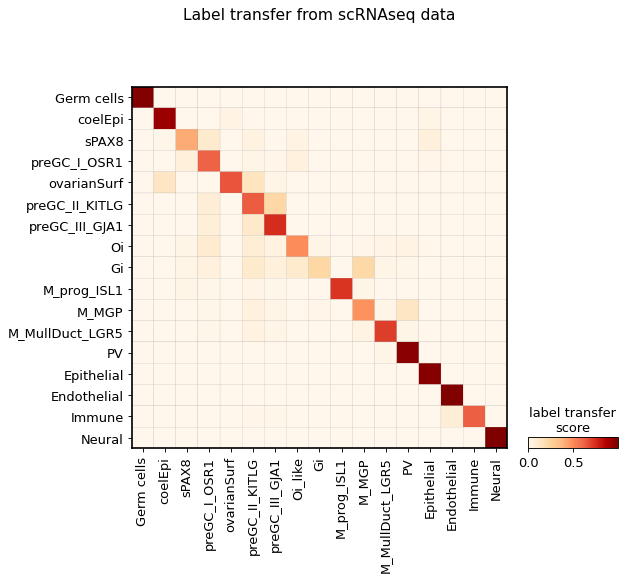

In [27]:
ordered_probs_present = [ 'Germ cells','coelEpi',  'sPAX8', 'preGC_I_OSR1',
                                                 'ovarianSurf','preGC_II_KITLG', 'preGC_III_GJA1',
                                                  'Oi_like',  'Gi', 
                                                 'M_prog_ISL1', 'M_MGP', 'M_MullDuct_LGR5', 
                                                 'PV','Epithelial', 'Endothelial', 'Immune', 'Neural']
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs_present, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot_present.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

### Import annotations from dualRNA Luz 

In [28]:
annotations_dualRNA = pd.read_csv("/nfs/team292/lg18/with_valentina/dual_snRNAsnATAC_female_Hrv39_scmap_predictions_highRes.csv", index_col = 0)
annotations_dualRNA.head()

scmap_labels  scmap_similarities
HD_F_GON9525421_AAACAGCCAACAACAA  M_MullDuct_LGR5            0.513360
HD_F_GON9525421_AAACCAACACCTACTT       Epithelial            0.794087
HD_F_GON9525421_AAACCGAAGCCTGGTA              PGC            0.701481
HD_F_GON9525421_AAACCGCGTATCTGGA  M_MullDuct_LGR5            0.538323
HD_F_GON9525421_AAACGCGCACCTCACC       unassigned            0.462028

In [29]:
annotations_dualRNA = annotations_dualRNA[annotations_dualRNA['scmap_similarities'] > 0.5]

In [30]:
adata.obs[['code', 'sample']].value_counts()

code  sample         
07    HD_F_GON9479874    12184
05    HD_F_GON9479871     9315
06    HD_F_GON9479873     8586
01    FCA_GND8046539      8553
08    HD_F_GON9479875     8056
11    HD_F_GON9883959     5232
12    HD_F_GON9883960     4912
04    FCA_GND8768485      4674
03    FCA_GND8768484      3391
02    FCA_GND8768483      1163
10    HD_F_GON9525614      761
09    HD_F_GON9525613      375
dtype: int64

 * ATAC 13 --> RNA 21, code = 09
 * ATAC 14 --> RNA 22, code = 10

In [31]:
annotations_dualRNA.index = [i.replace("HD_F_GON9525421_", "09-") for i in annotations_dualRNA.index]

In [32]:
annotations_dualRNA.index = [i.replace("HD_F_GON9525422_", "10-") for i in annotations_dualRNA.index]

In [33]:
annotations_dualRNA.index = [i + "-1" for i in annotations_dualRNA.index]

In [34]:
annotations_dualRNA['scmap_labels'].value_counts(dropna = False)

M_MullDuct_LGR5     1519
M_ALX1               397
preGC_II             324
M_MGP                285
PGC                   86
preGC_II_hypoxia      73
ovarianSurf           70
Endothelial           70
Epithelial            55
Oi                    51
Neural                32
Gi                    31
preGC_III             23
oogonia_STRA8         22
Immune                21
M_prog_ISL1           11
sKITLG                10
preGC_III_Notch        7
sPAX8b                 7
PV                     6
preGC_I_OSR1           4
Erythroid              2
oogonia_meiosis        2
Name: scmap_labels, dtype: int64

In [84]:
annotations_dualRNA = annotations_dualRNA[annotations_dualRNA['scmap_labels'] != 'preGC_I_OSR1']
annotations_dualRNA = annotations_dualRNA[annotations_dualRNA['scmap_labels'] != 'Erythroid']
annotations_dualRNA = annotations_dualRNA[annotations_dualRNA['scmap_labels'] != 'preGCm_OSR1']

In [85]:
annotations_dualRNA['scmap_labels'] = ['Germ cells' if i in ['PGC', 'PGC_mitotic', 'oogonia_STRA8',
                                    'GC_mitotic', 'PGC_XIST'] else i for i in annotations_dualRNA['scmap_labels']]
annotations_dualRNA['scmap_labels'].value_counts(dropna = False)

Stromal          2132
sKITLG            292
Germ cells        151
preGCc_CSRNP1     151
Endothelial        69
Epithelial         61
ovarianSurf        52
sLGR5              37
PV                 35
Immune             22
preGC_RDH10        12
sPAX8               9
Name: scmap_labels, dtype: int64

In [86]:
dualRNA_mapping = annotations_dualRNA['scmap_labels'].to_dict()
adata.obs['dualRNA_label'] = adata.obs_names.map(dualRNA_mapping)
adata.obs['dualRNA_label'].value_counts(dropna = False)

NaN              66516
sKITLG             202
preGCc_CSRNP1      116
Germ cells         111
Endothelial         63
Epithelial          56
ovarianSurf         39
Stromal             37
sLGR5               29
Immune              21
sPAX8                7
preGC_RDH10          5
Name: dualRNA_label, dtype: int64

In [87]:
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].astype(str)
adata.obs['dualRNA_label'] = ["scATACseq_only"  if i == "nan" else i for i in adata.obs['dualRNA_label']]

In [ ]:
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].astype("category")
adata.obs['dualRNA_label'] = adata.obs['dualRNA_label'].cat.reorder_categories([
                       'Germ cells', 
                   'sLGR5',  'sKITLG', 'ovarianSurf', 'preGCc_CSRNP1', 'preGC_RDH10','sPAX8', 
                'Stromal', 'PV', 'Epithelial', 'Endothelial', 'Immune',
                   'scATACseq_only'])

In [46]:
new_palette = ['#c466b0', '#e64e74', '#aad3f2',  '#60bddb',   "#70ccbe",'#71a2c7','#bdb380',
               '#d4db81', '#ebd3c3','#60bddb',  '#e08b8b', '#edb7b7','aliceblue', '#edb7b7', '#d9abb7', '#d96884', '#e64e74', '#d9a5c3', '#cc8fdb', 'aliceblue']

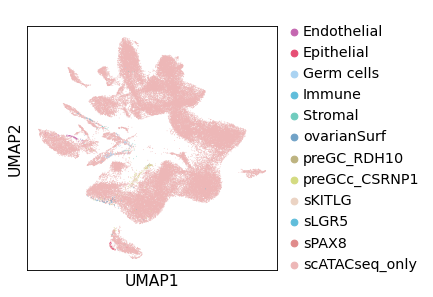

In [90]:
sc.pl.umap(adata, color = "dualRNA_label", save = "_dual_females.pdf", palette = new_palette, 
          title = " ")

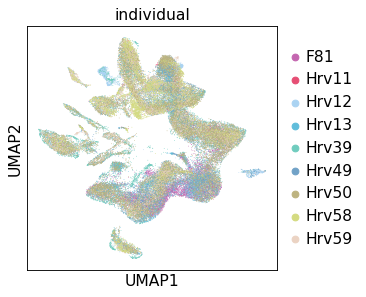

In [47]:
sc.pl.umap(adata, color='individual',legend_fontsize = 'medium', legend_fontweight = 'medium',
           save='_females_individual.pdf', palette = new_palette)

In [48]:
# Transform the stage variable in numeric to plot the PCW as a gradient
pcws_dict = {'11 PCW' : 11, '12 PCW' : 12, '13 PCW' : 13, '14 PCW' : 14, '15 PCW' : 15, '17 PCW' : 17,
       '18 PCW' : 18, '19 PCW' : 19, '21 PCW' : 21, '7 PCW' : 7, '8 PCW' : 8, '9 PCW' : 9}
adata.obs['stage_numeric'] = adata.obs['stage'].map(pcws_dict)
adata.obs['stage_numeric'].value_counts(dropna = False)
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(float)

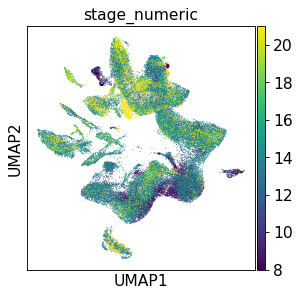

In [49]:
sc.pl.umap(adata, color='stage_numeric',legend_fontsize = 'medium', 
           legend_fontweight = 'medium', color_map = 'viridis',
           save='_female_stage.pdf')

#### Annotate cells based on label transfer + dual RNA annotations

In [73]:
label_transfer = ['preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf',
       'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP',
       'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV',
       'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune',
       'M_MullDuct_LGR5', ]

In [97]:
cell_type = {'0' : 'preGC_II_KITLG', '1' : 'preGC_I_OSR1', '2' : 'Oi', '3' : 'M_MullDuct_LGR5',
            '4' : 'Gi', '5' : 'preGC_III_GJA1', '6' : 'M_MGP', '7' : 'M_MGP', '9' : 'M_MGP',
            '10' : 'M_MGP', '8' : 'ovarianSurf', '11' : 'Endothelial', '19' : 'Endothelial', 
            '12' : 'PV', '13' : 'Epithelial', '14' : 'coelEpi', '15' : 'Germ cells', '18' : 'Germ cells',
            '16' : 'Immune', '17' : 'M_prog_ISL1', '20' : 'sPAX8', '21' : 'Neural', '22' : 'Neural', 
            '23' : 'preGC_II_KITLG'}
adata.obs['cell_type'] = adata.obs['leiden'].map(cell_type)
adata.obs['cell_type'].value_counts(dropna = False)

M_MGP              14131
preGC_II_KITLG      7300
preGC_I_OSR1        6881
Oi                  6815
M_MullDuct_LGR5     5322
Gi                  5262
preGC_III_GJA1      4591
Endothelial         3588
ovarianSurf         3496
PV                  2529
Germ cells          1618
Epithelial          1598
Neural               937
coelEpi              895
Immune               818
M_prog_ISL1          806
sPAX8                615
Name: cell_type, dtype: int64

In [14]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories([
   'Germ cells',
                                                 'coelEpi',  'sPAX8', 'preGC_I_OSR1',
                                                 'ovarianSurf','preGC_II_KITLG', 'preGC_III_GJA1',
                                                  'Oi',  'Gi', 
                                                 'M_prog_ISL1', 'M_MGP', 'M_MullDuct_LGR5', 
                                                 'PV','Epithelial', 'Endothelial', 'Immune', 'Neural'
])

In [15]:
gonads_colors = ['#ff0000', # germs
                  '#366b36', '#4b944a', # sup
                  '#d9439a', '#ffb5ca', '#ff6390',  '#f582c5', # preGC
                  '#fcbdc4', '#94714e', # Gi and Oi
                  '#e6dec8', '#f5eecb',  '#edcba8',
                  '#ffc266', '#d98200', '#e36a1e',  '#ffb485',  # other
                  '#b5b5b5' ]

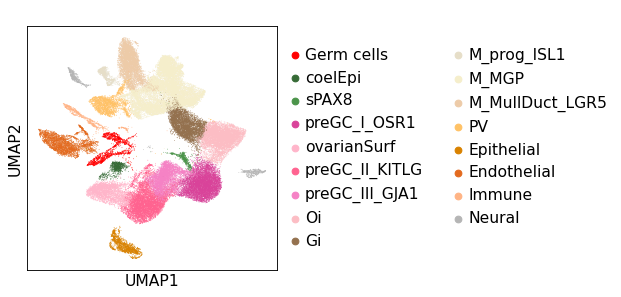

In [16]:
sc.pl.umap(adata, color = 'cell_type', palette = gonads_colors, 
           legend_fontsize = "medium", legend_fontweight = "medium", frameon = True, 
           title = " ",
           save = "_annotations_females.pdf", )

In [103]:
adata.write(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")

In [9]:
adata = sc.read(outdir + experiment_prefix + "_harmony_ATACwCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 67202 × 201343
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'leiden', 'preGC_III_GJA1', 'preGC_II_KITLG', 'sLGR5', 'ovarianSurf', 'preGC_I_OSR1', 'Gi', 'Oi', 'Oi_like', 'Endothelial', 'sPAX8', 'M_MGP', 'M_MullDuct_AMHR2', 'Epithelial', 'coelEpi', 'Neural', 'sKITLG', 'PV', 'Germ cells', 'Erythroid', 'M_ALX1', 'M_prog_ISL1', 'Immune', 'M_MullDuct_LGR5', 'max', 'dualRNA_label', 'leiden_R', 'cell_type'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'cellat

In [10]:
adata.shape

(67202, 201343)

In [11]:
np.unique(adata.obs['individual'])

array(['F81', 'Hrv11', 'Hrv12', 'Hrv13', 'Hrv39', 'Hrv49', 'Hrv50',
       'Hrv58', 'Hrv59'], dtype=object)

In [121]:
adata.obs[['individual', 'sample', 'stage']].value_counts()

individual  sample           stage 
Hrv50       HD_F_GON9479874  14 PCW    12184
Hrv39       HD_F_GON9479871  14 PCW     9315
Hrv49       HD_F_GON9479873  13 PCW     8586
F81         FCA_GND8046539   8 PCW      8553
Hrv50       HD_F_GON9479875  14 PCW     8056
Hrv59       HD_F_GON9883959  18 PCW     5232
Hrv58       HD_F_GON9883960  21 PCW     4912
Hrv13       FCA_GND8768485   9 PCW      4674
Hrv12       FCA_GND8768484   8 PCW      3391
Hrv11       FCA_GND8768483   14 PCW     1163
Hrv39       HD_F_GON9525614  14 PCW      761
            HD_F_GON9525613  14 PCW      375
dtype: int64

In [122]:
adata.obs[['individual','stage']].value_counts()

individual  stage 
Hrv50       14 PCW    20240
Hrv39       14 PCW    10451
Hrv49       13 PCW     8586
F81         8 PCW      8553
Hrv59       18 PCW     5232
Hrv58       21 PCW     4912
Hrv13       9 PCW      4674
Hrv12       8 PCW      3391
Hrv11       14 PCW     1163
dtype: int64

In [123]:
adata.obs['stage'].value_counts()

14 PCW    31854
8 PCW     11944
13 PCW     8586
18 PCW     5232
21 PCW     4912
9 PCW      4674
Name: stage, dtype: int64

#### Save adata.var to annotated for CICERO

In [31]:
adata.var['peaks_formatted'] = [i.replace(":", "-") for i in adata.var_names]

In [32]:
adata.var = adata.var.set_index('peaks_formatted')
adata.var.to_csv(outdir + experiment_prefix + "adata_var_for_cicero.csv")

#### End of notebook